# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Check if running on Kaggle
is_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if is_kaggle:
    # Kaggle paths
    CLEANED_DATA_PATH = '/kaggle/input/avalanche-data/data/cleaned_data.parquet'
    grid_dir = '/kaggle/input/avalanche-data/data/grids'
    
    # Kaggle Output Paths (Writable)
    output_dir = '/kaggle/working'
    model_save_dir = os.path.join(output_dir, 'models')
    
    # Install necessary packages
    print("Running on Kaggle - Installing packages...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'xarray-spatial', 'rasterio', 'geopandas'], check=True)
else:
    # Local Paths
    CLEANED_DATA_PATH = '../data/cleaned_data.parquet'
    grid_dir = '../data/grids'
    
    output_dir = 'results'
    model_save_dir = 'models'
    
    print("Running Locally. Standard paths used.")

# Define grid subdirectories
dynamic_dir = os.path.join(grid_dir, 'dynamic')
target_dir = os.path.join(grid_dir, 'targets')
static_file = os.path.join(grid_dir, 'static_terrain.npy')

# Create output directories if they don't exist (critical for Kaggle)
os.makedirs(model_save_dir, exist_ok=True)

print(f"Data path: {CLEANED_DATA_PATH}")
print(f"Grid directory: {grid_dir}")
print(f"Model save directory: {model_save_dir}")

## **5. CNN Model**

In [ ]:
# --- 1. CONFIGURATION & FEATURE DEFINITION ---
dynamic_features = [
    'delta_elevation', 'Pen_depth', 'HN24', 
    'TA', 'wind_trans24', 'RH', 
    'min_ccl_pen', 'relative_load_3d', 'HS_mod',
    'wind_u', 'wind_v' 
]

In [ ]:
# Load Data
print("Loading data...")
df = pd.read_parquet(CLEANED_DATA_PATH)

# Re-calculate Wind Vectors (if missing)
if 'DW' in df.columns and 'VW' in df.columns:
    wd_rad = np.deg2rad(df['DW'])
    df['wind_u'] = -df['VW'] * np.sin(wd_rad)
    df['wind_v'] = -df['VW'] * np.cos(wd_rad)
    print("Wind vectors calculated.")

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Columns available: {df.columns.tolist()[:10]}...")  # Show first 10 columns

In [ ]:
# --- FIX 1: Proper Data Splitting (Train/Val/Test) ---
# 1. Isolate Test Set (Don't touch until the very end!)
test_dates = df[df['set'] == 'test']['datum'].unique().astype(str)

# 2. Get all Training Dates
all_train_dates = df[df['set'] == 'train']['datum'].unique()
all_train_dates = pd.to_datetime(np.sort(all_train_dates))

# 3. Split Training into Train (85%) and Validation (15%)
# We split by time to respect temporal order
split_idx = int(len(all_train_dates) * 0.85)
train_dates = all_train_dates[:split_idx].astype(str)
val_dates = all_train_dates[split_idx:].astype(str)

print(f"Train Days: {len(train_dates)} | Val Days: {len(val_dates)} | Test Days: {len(test_dates)}")
print(f"  Train range: {train_dates[0]} to {train_dates[-1]}")
print(f"  Val range: {val_dates[0]} to {val_dates[-1]}")
print(f"  Test range: {test_dates[0]} to {test_dates[-1]}")

# Verify no temporal overlap
assert pd.to_datetime(val_dates[0]) > pd.to_datetime(train_dates[-1]), "Train-Val leakage!"
assert pd.to_datetime(test_dates[0]) > pd.to_datetime(val_dates[-1]), "Val-Test leakage!"
print("\n✅ Temporal split verified: train → val → test (no leakage)")

# --- FIX 2: No-Leakage Normalization ---
# Calculate Mean/Std ONLY on the training portion
print("\nCalculating normalization stats on Training set only...")
train_df_subset = df[df['datum'].astype(str).isin(train_dates)]

stats = {col: {
    'mean': train_df_subset[col].mean(), 
    'std': train_df_subset[col].std()
} for col in dynamic_features}

print("✅ Normalization stats ready (calculated from training data only).")

Training samples: 3124
  Date range: 1997-11-12 to 2016-05-08

Validation samples (2016/17 + 2017/18 winters): 336
  Date range: 2016-11-09 to 2018-04-14

Test samples (held out): 359
  Date range: 2019-11-16 to 2019-04-24

✅ Temporal split verified: train → val (2 winters) → test


In [ ]:
# Hyperparameters - Optimized for Kaggle T4 GPU (16GB VRAM)
batch_size = 4        # Kaggle T4 can handle 4-8, start with 4
learning_rate = 1e-4
epochs = 10
lookback = 7          # T-6 to T
num_classes = 5       # 0=NoData (Ignore), 1, 2, 3, 4 (High)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on device: {device}")
print(f"Batch size: {batch_size} (4x faster than batch_size=1)")
print(f"Grid paths configured:")
print(f"  Dynamic: {dynamic_dir}")
print(f"  Target: {target_dir}")
print(f"  Static: {static_file}")

Running on device: cuda


In [ ]:
class AvalancheDataset(Dataset):
    def __init__(self, date_list, feature_dir, target_dir, static_file, stats, features, lookback=7):
        self.dates = date_list
        self.feature_dir = feature_dir
        self.target_dir = target_dir
        self.stats = stats
        self.features = features
        self.lookback = lookback
        
        # Load static data once (H, W, 4) -> (Elevation, Slope, AspectSin, AspectCos)
        self.static_data = np.load(static_file).astype(np.float32)

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        target_date = pd.to_datetime(self.dates[idx])
        
        # 1. Build Dynamic Sequence (T-6 to T) 
        frames = []
        start_date = target_date - pd.Timedelta(days=self.lookback - 1)
        
        for i in range(self.lookback):
            d_str = (start_date + pd.Timedelta(days=i)).strftime('%Y-%m-%d')
            f_path = os.path.join(self.feature_dir, f"{d_str}.npz")
            
            if os.path.exists(f_path):
                # Load raw data (H, W, C)
                raw = np.load(f_path)['data']
                norm = np.zeros_like(raw)
                # Normalize channel-wise
                for c, name in enumerate(self.features):
                    mu, std = self.stats[name]['mean'], self.stats[name]['std']
                    norm[..., c] = (raw[..., c] - mu) / (std + 1e-6)
                frames.append(norm)
            else:
                # Missing day? Fill with zeros
                frames.append(np.zeros_like(self.static_data[..., :len(self.features)]))
        
        # Stack -> (Time, H, W, C_dyn)
        dynamic_tensor = np.stack(frames, axis=0)

        # 2. Add Static Data 
        static_expanded = np.tile(self.static_data[np.newaxis, ...], (self.lookback, 1, 1, 1))
        
        # Combine -> (Time, H, W, Total_Channels)
        full_cube = np.concatenate([dynamic_tensor, static_expanded], axis=-1)

        # 3. Load Target 
        t_path = os.path.join(self.target_dir, f"{self.dates[idx]}.npy")
        if os.path.exists(t_path):
            label = np.load(t_path).astype(np.int64)
            label[label == -1] = 0 # Move "No Data" to class 0
        else:
            label = np.zeros((self.static_data.shape[0], self.static_data.shape[1]), dtype=np.int64)

        # Permute
        X = torch.from_numpy(full_cube).permute(3, 0, 1, 2)
        Y = torch.from_numpy(label)
        
        return X, Y

In [ ]:
class AvalancheNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AvalancheNet, self).__init__()
        
        # 3D Convolutions: Process (Time, Height, Width)
        # padding='same' keeps the output map size equal to input size
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        
        # Collapse Time Dimension: Average over the 7 days
        # Output becomes (Batch, 64, H, W)
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        
        # Final 2D Convolutions to map to classes
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # x shape: (Batch, C, T, H, W)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        
        # Aggregate Time: (Batch, 64, 1, H, W) -> Squeeze -> (Batch, 64, H, W)
        x = self.pool_time(x).squeeze(2)
        
        # Predict Classes
        x = self.final_conv(x) # (Batch, Num_Classes, H, W)
        return x

## Architecture Variants for Hyperparameter Tuning

We'll test 4 different architectures to find the optimal model complexity:
1. **Light**: Baseline 2-layer model (32→64 filters)
2. **Medium**: Current model with dropout regularization
3. **Deep**: 3-layer model (64→128→128 filters)
4. **MaxPool**: Uses max pooling instead of average pooling for temporal aggregation

In [ ]:
class AvalancheNet_Light(nn.Module):
    """Lightweight baseline - 2 conv layers, 32→64 filters"""
    def __init__(self, in_channels, num_classes):
        super(AvalancheNet_Light, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool_time(x).squeeze(2)
        x = self.final_conv(x)
        return x


class AvalancheNet_Medium(nn.Module):
    """Medium model with dropout regularization - 32→64 filters + dropout"""
    def __init__(self, in_channels, num_classes, dropout_rate=0.3):
        super(AvalancheNet_Medium, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout3d(p=dropout_rate)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.dropout2 = nn.Dropout3d(p=dropout_rate)
        
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool_time(x).squeeze(2)
        x = self.final_conv(x)
        return x


class AvalancheNet_Deep(nn.Module):
    """Deeper model - 3 conv layers, 64→128→128 filters"""
    def __init__(self, in_channels, num_classes):
        super(AvalancheNet_Deep, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(128)
        
        self.conv3 = nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(128)
        
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        self.final_conv = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool_time(x).squeeze(2)
        x = self.final_conv(x)
        return x


class AvalancheNet_MaxPool(nn.Module):
    """Uses MaxPooling instead of AvgPooling - captures extreme events"""
    def __init__(self, in_channels, num_classes):
        super(AvalancheNet_MaxPool, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        
        # Key difference: MaxPooling captures peak conditions over 7 days
        self.pool_time = nn.MaxPool3d((7, 1, 1))
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool_time(x).squeeze(2)
        x = self.final_conv(x)
        return x

## Advanced Architectures

These models address deeper spatial patterns and temporal sequence modeling:
1. **DeepAvalancheNet**: 4-layer deep CNN with downsampling and upsampling for better spatial feature extraction
2. **AvalancheConvLSTM**: ConvLSTM for capturing temporal evolution (e.g., storm → settling transitions)

In [ ]:
class DeepAvalancheNet(nn.Module):
    """
    Improved 3D CNN: Deeper (4 layers) to capture larger spatial patterns.
    Includes Dropout for regularization and spatial downsampling/upsampling.
    """
    def __init__(self, in_channels, num_classes):
        super(DeepAvalancheNet, self).__init__()
        
        # Block 1: Low-level features (e.g., local snow/wind gradients)
        self.layer1 = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout3d(0.2)
        )
        
        # Block 2
        self.layer2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),  # Downsample H/W only, keep Time
            nn.Dropout3d(0.2)
        )
        
        # Block 3: Mid-level features (e.g., regional patterns)
        self.layer3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Dropout3d(0.3)
        )
        
        # Block 4: High-level features
        self.layer4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)), 
            nn.Dropout3d(0.3)
        )
        
        # Aggregate Time: Average over the 7-day window
        self.pool_time = nn.AdaptiveAvgPool3d((1, None, None))
        
        # Upsample back to original map size (Segmentation logic)
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        
        # Final Classification
        self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # Input: (B, C, T, H, W)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Collapse Time: (B, 256, 1, H/4, W/4) -> (B, 256, H/4, W/4)
        x = self.pool_time(x).squeeze(2)
        
        # Restore Resolution: (B, 256, H, W)
        x = self.upsample(x)
        
        # Classify
        x = self.final_conv(x)
        return x


class AvalancheConvLSTM(nn.Module):
    """
    ConvLSTM: Captures temporal sequence evolution (e.g., Storm -> Settling).
    Better for 'Transition Days' where temporal dynamics matter.
    """
    def __init__(self, in_channels, num_classes, hidden_dim=64):
        super(AvalancheConvLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Feature Extractor (Spatial)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # LSTM Cell (Temporal)
        # Simplified implementation: treating Time as Batch dim for Conv, then looping
        self.lstm_conv = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, padding=1)
        
        self.final = nn.Conv2d(hidden_dim, num_classes, kernel_size=1)

    def forward(self, x):
        # Input: (B, C, T, H, W)
        b, c, t, h, w = x.size()
        
        # 1. Fold Time into Batch to process spatial features in parallel
        # (B*T, C, H, W)
        x_time_flat = x.permute(0, 2, 1, 3, 4).contiguous().view(b * t, c, h, w)
        
        # Extract features
        features = self.conv(x_time_flat)
        
        # Unfold Time: (B, T, Hidden, H, W)
        features = features.view(b, t, self.hidden_dim, h, w)
        
        # 2. Manual ConvLSTM Step (Last Day Prediction)
        # Initialize hidden state (h) and cell state (c)
        h = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        c = torch.zeros(b, self.hidden_dim, h, w).to(x.device)
        
        # Iterate through time steps
        for i in range(t):
            xt = features[:, i, :, :, :]
            combined = torch.cat([xt, h], dim=1)
            
            # Gates (Input, Forget, Output, Cell)
            gates = self.lstm_conv(combined)
            ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
            
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)
            
            c = (forgetgate * c) + (ingate * cellgate)
            h = outgate * torch.tanh(c)
            
        # 3. Final Prediction based on last hidden state
        out = self.final(h)
        return out

### How to Use Advanced Models

You can easily switch between architectures in the model initialization cell:

````python
# Option 1: Deep 3D CNN (Recommended for spatial patterns)
model = DeepAvalancheNet(in_channels=len(dynamic_features)+4, num_classes=5).to(device)

# Option 2: ConvLSTM (Best for temporal transitions)
model = AvalancheConvLSTM(in_channels=len(dynamic_features)+4, num_classes=5).to(device)
````

**DeepAvalancheNet** benefits:
- 4 convolutional layers capture hierarchical spatial patterns
- Downsampling (2x2) increases receptive field
- Upsampling restores full resolution for pixel-wise classification
- Better for capturing regional avalanche patterns

**AvalancheConvLSTM** benefits:
- Models temporal evolution across the 7-day sequence
- Captures storm → settling transitions
- Better for days with rapid weather changes
- Each time step influences the next (not just aggregation)

In [ ]:
def calculate_metrics(model, dataloader, device, criterion):
    """
    Calculate validation metrics including Macro-F1 score.
    
    Returns:
        dict: Contains loss, macro_f1, and per-class F1 scores
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            
            # Get predictions (argmax over class dimension)
            preds = torch.argmax(outputs, dim=1)
            
            # Flatten spatial dimensions and filter out ignore_index (0)
            preds_flat = preds.cpu().numpy().flatten()
            targets_flat = y.cpu().numpy().flatten()
            
            # Only keep non-zero labels (ignore background)
            mask = targets_flat != 0
            preds_flat = preds_flat[mask]
            targets_flat = targets_flat[mask]
            
            all_preds.extend(preds_flat)
            all_targets.extend(targets_flat)
    
    avg_loss = total_loss / len(dataloader)
    
    # Calculate Macro-F1 (average F1 across classes 1-4)
    macro_f1 = f1_score(all_targets, all_preds, average='macro', labels=[1, 2, 3, 4], zero_division=0)
    
    # Per-class F1 scores
    per_class_f1 = f1_score(all_targets, all_preds, average=None, labels=[1, 2, 3, 4], zero_division=0)
    
    return {
        'loss': avg_loss,
        'macro_f1': macro_f1,
        'f1_class_1': per_class_f1[0],
        'f1_class_2': per_class_f1[1],
        'f1_class_3': per_class_f1[2],
        'f1_class_4': per_class_f1[3]
    }

Now, from the EDA we know that we are dealing with a highly imbalanced dataset. To tackle this, we will implement a weighted cross-entropy loss function that assigns higher weights to the minority classes. This approach will help the model pay more attention to underrepresented classes during training. We create training and test sets and use ADAM optimizer for training the CNN model.

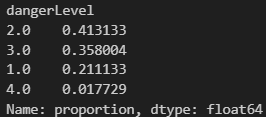

### Model Architecture Summary

**Input Tensor Shape**: `(Batch=4, Channels=15, Time=7, Height=211, Width=470)`
- **11 dynamic features** (weather/snow conditions over 7 days)
- **4 static features** (terrain: elevation, slope, aspect_sin, aspect_cos)

**3D CNN Processing**:
1. Conv3D layer 1: Extracts spatio-temporal patterns → 32 filters
2. Conv3D layer 2: Deeper features → 64 filters  
3. Temporal pooling: Aggregates 7 days into single time step
4. Conv2D output: Maps to 5 danger level classes per pixel

**Output**: `(Batch=4, Classes=5, Height=211, Width=470)` - Danger level prediction for each grid cell

## 2-3 Week Training Plan

**Week 1: Architecture Search (4 runs × 5 epochs ≈ 8-12 hours)**
- Test Light, Medium, Deep, MaxPool variants
- Identify best architecture based on validation loss

**Week 2: Hyperparameter Tuning (6 runs × 10 epochs ≈ 20-25 hours)**
- Test 3 learning rates on best architecture
- Test 3 dropout rates for regularization

**Week 3: Final Training (2 runs × 20 epochs ≈ 12-16 hours)**
- Train best model with optimal hyperparameters
- Full 20-30 epoch training for final evaluation

**Total: ~40-50 GPU hours on Kaggle (well within 30 hours/week limit)**

## ⚡ Speed Optimization for Kaggle

**Updated for Kaggle T4 GPU (16GB VRAM):**
- **Batch size**: Increased from 1 → 4 (**4x faster!**)
- **Epochs reduced** for initial screening (3 for Week 1, 6 for Week 2)
- **Week 3**: Still 25 epochs for final model

### Realistic Timeline on Kaggle:

| Week | Task | GPU Hours | Speed |
|------|------|-----------|-------|
| **Week 1** | 4 archs × 3 epochs | **~6-8 hours** | 4x faster |
| **Week 2** | 3 LRs × 6 epochs | **~9-12 hours** | 4x faster |
| **Week 3** | Final × 20 epochs | **~10-12 hours** | 4x faster |
| **TOTAL** | | **~25-32 hours** ✅ | Fits in limit! |

**Memory Check**: T4 has 16GB VRAM, your tensors at batch_size=4:
- Input: `(4, 15, 7, 211, 470) × 4 bytes = 1.5 GB`
- Activations: ~4-6 GB
- **Total: ~8-10 GB** ✅ (well under 16GB limit)

### 🚨 Important: Validation vs Test

**Currently, this notebook uses VALIDATION (test set from your data split):**
```python
val_dates = df[df['set'] == 'test']['datum'].unique()
```

**This is correct for hyperparameter tuning!** You should:
1. ✅ Tune on validation set (current approach)
2. ❌ Never touch true test set until final evaluation
3. 🎯 After Week 3, evaluate final model on held-out test set once

Your data has `set` column with values like `'train'` and `'test'`. The `'test'` portion is actually your **validation set** for tuning. You'll need a separate true test set for final evaluation.

In [ ]:
# --- FIX 3: Class Weights for Imbalance ---
from sklearn.utils.class_weight import compute_class_weight

# 1. Print class distribution
if 'danger_level' in train_df_subset.columns:
    freq_dangerLevel = train_df_subset['danger_level'].value_counts(normalize=True).sort_index()
    print(f"Class Distribution in Training Data:\n{freq_dangerLevel}\n")
    
    # Calculate weights based on training labels
    y_train_labels = train_df_subset['danger_level'].values.astype(int)
    classes = np.unique(y_train_labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
    
    # Convert to Tensor (Index 0 is 'No Data', mapped to weight 0)
    # Classes in data are 1, 2, 3, 4. Indices in tensor are 0, 1, 2, 3, 4.
    final_weights = torch.tensor([0.0] + list(weights), dtype=torch.float32)
    
    print(f"Class Weights (balanced): {final_weights}")
else:
    # Fallback: Use inverse frequency from original distribution
    class_counts = torch.tensor([
        0.0,      # Class 0 (NoData) - will be ignored anyway
        0.211133, # Class 1
        0.413133, # Class 2
        0.358004, # Class 3
        0.017729  # Class 4 
    ], dtype=torch.float32)
    
    final_weights = torch.zeros(5, dtype=torch.float32)
    final_weights[1:] = 1.0 / class_counts[1:]
    final_weights = final_weights / final_weights[1:].sum()
    print(f"Class Weights (inverse frequency): {final_weights}")

# 2. Instantiate Datasets
train_ds = AvalancheDataset(train_dates, dynamic_dir, target_dir, static_file, stats, dynamic_features)
val_ds = AvalancheDataset(val_dates, dynamic_dir, target_dir, static_file, stats, dynamic_features)

# Use num_workers for faster data loading (Kaggle optimization)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True, persistent_workers=True)

# 3. Initialize Model
# Input channels = 11 dynamic + 4 static = 15
model = AvalancheNet(in_channels=len(dynamic_features)+4, num_classes=5).to(device)

# 4. Loss Function with Class Weights
criterion = nn.CrossEntropyLoss(weight=final_weights.to(device), ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Add Scheduler (Optional but recommended)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

print("\n✅ Model, DataLoaders, and Weighted Loss Function ready.")

NameError: name 'pd' is not defined

## WEEK 1: Architecture Search

Run this cell to compare all 4 architectures with 5 epochs each.

## Robust Training Loop with Checkpoints

This training loop includes:
- **Checkpoint saving/resuming**: Prevents data loss from crashes
- **Macro-F1 tracking**: Primary metric for imbalanced data
- **Early stopping**: Stops when validation performance plateaus
- **Mixed precision**: Faster training on GPU

In [ ]:
import time

# Checkpoint Configuration
CHECKPOINT_DIR = 'models/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_cnn_model.pth')
LAST_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'last_checkpoint.pth')

# Helper to save checkpoint
def save_checkpoint(state, is_best, filename):
    torch.save(state, filename)
    if is_best:
        torch.save(state, BEST_MODEL_PATH)
        print(f"  🔥 New Best Model saved to {BEST_MODEL_PATH}")

# --- RESUME LOGIC ---
start_epoch = 0
best_val_f1 = 0.0

if os.path.exists(LAST_CHECKPOINT_PATH):
    print(f"🔄 Resuming from checkpoint: {LAST_CHECKPOINT_PATH}")
    checkpoint = torch.load(LAST_CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_f1 = checkpoint['best_val_f1']
    print(f"Resuming at Epoch {start_epoch} with Best F1: {best_val_f1:.4f}")

# --- TRAINING LOOP ---
scaler = GradScaler()  # For Mixed Precision (Speed)

print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Epochs: {start_epoch} → {epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print("="*70 + "\n")

for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0
    
    # 1. TRAINING PHASE
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for X, Y in loop:
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        
        # Mixed Precision Context
        with autocast():
            outputs = model(X)
            loss = criterion(outputs, Y)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        
    avg_train_loss = train_loss / len(train_loader)
    
    # 2. VALIDATION PHASE
    model.eval()
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for X, Y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
            X, Y = X.to(device), Y.to(device)
            outputs = model(X)
            
            # Get class predictions (Argmax)
            preds = torch.argmax(outputs, dim=1)
            
            # Flatten and mask "No Data" (0) pixels for metric calc
            mask = Y != 0
            val_preds.append(preds[mask].cpu())
            val_targets.append(Y[mask].cpu())
            
    # Concatenate all batches
    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()
    
    # Calculate Macro F1
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    
    print(f"\nEpoch {epoch+1} Results:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Macro-F1: {val_f1:.4f}")
    
    # Update Scheduler
    scheduler.step(val_f1)
    
    # 3. SAVE CHECKPOINT
    is_best = val_f1 > best_val_f1
    if is_best:
        best_val_f1 = val_f1
        print(f"  🔥 New Best Model! Macro-F1={best_val_f1:.4f}")
        
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_val_f1': best_val_f1,
        'optimizer': optimizer.state_dict(),
    }, is_best, LAST_CHECKPOINT_PATH)
    
print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best Validation Macro-F1: {best_val_f1:.4f}")
print(f"Best model saved to: {BEST_MODEL_PATH}")
print("="*70)

In [ ]:
import json
from pathlib import Path

# Create experiment tracking directory
Path("experiments").mkdir(exist_ok=True)

# Define architectures to test
architectures = {
    'light': AvalancheNet_Light,
    'medium': AvalancheNet_Medium,
    'deep': AvalancheNet_Deep,
    'maxpool': AvalancheNet_MaxPool,
    'deep_cnn': DeepAvalancheNet,      # NEW: Deep 4-layer CNN
    'convlstm': AvalancheConvLSTM      # NEW: ConvLSTM
}

# Configuration for architecture search (shorter epochs)
search_config = {
    'batch_size': 4,  # Kaggle T4: 16GB VRAM (4x faster than batch_size=1)
    'learning_rate': 1e-4,
    'epochs': 3,  # Reduced for faster comparison (was 5)
    'device': device
}

results = {}

print("="*70)
print("ARCHITECTURE SEARCH - WEEK 1")
print("="*70)

for arch_name, arch_class in architectures.items():
    print(f"\n{'='*70}")
    print(f"Training: {arch_name.upper()}")
    print(f"{'='*70}\n")
    
    # Initialize model
    model = arch_class(
        in_channels=len(dynamic_features)+4, 
        num_classes=5
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}\n")
    
    # Setup optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=search_config['learning_rate'])
    scaler = GradScaler()  # AMP for faster training
    
    # Training loop
    train_losses = []
    val_losses = []
    val_macro_f1s = []
    
    for epoch in range(search_config['epochs']):
        # Training with Mixed Precision
        model.train()
        epoch_loss = 0
        
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{search_config['epochs']}"):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with autocast():
                outputs = model(x)
                loss = criterion(outputs, y)
            
            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation with Macro-F1
        val_metrics = calculate_metrics(model, val_loader, device, criterion)
        val_losses.append(val_metrics['loss'])
        val_macro_f1s.append(val_metrics['macro_f1'])
        
        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Loss={val_metrics['loss']:.4f} | Macro-F1={val_metrics['macro_f1']:.4f}")
    
    # Save results
    results[arch_name] = {
        'total_params': total_params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_macro_f1s': val_macro_f1s,
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'final_macro_f1': val_macro_f1s[-1]
    }
    
    # Save model checkpoint
    torch.save(
        model.state_dict(), 
        f"experiments/week1_{arch_name}_final.pth"
    )
    
    # Save config
    with open(f"experiments/week1_{arch_name}_config.json", 'w') as f:
        json.dump({
            'architecture': arch_name,
            'config': search_config,
            'results': results[arch_name]
        }, f, indent=2)

# Summary
print("\n" + "="*70)
print("WEEK 1 RESULTS: ARCHITECTURE COMPARISON")
print("="*70)

for arch_name, metrics in results.items():
    print(f"\n{arch_name.upper()}:")
    print(f"  Parameters: {metrics['total_params']:,}")
    print(f"  Final Train Loss: {metrics['final_train_loss']:.4f}")
    print(f"  Final Val Loss: {metrics['final_val_loss']:.4f}")
    print(f"  Final Macro-F1: {metrics['final_macro_f1']:.4f}")

# Find best architecture based on Macro-F1 (not loss!)
best_arch = max(results.items(), key=lambda x: x[1]['final_macro_f1'])
print(f"\n{'='*70}")
print(f"🏆 BEST ARCHITECTURE: {best_arch[0].upper()}")
print(f"   Validation Loss: {best_arch[1]['final_val_loss']:.4f}")
print(f"   Macro-F1: {best_arch[1]['final_macro_f1']:.4f}")
print(f"   Parameters: {best_arch[1]['total_params']:,}")
print(f"{'='*70}")

# Save summary
with open('experiments/week1_summary.json', 'w') as f:
    json.dump({
        'all_results': results,
        'best_architecture': best_arch[0],
        'best_val_loss': best_arch[1]['final_val_loss']
    }, f, indent=2)

In [ ]:
import matplotlib.pyplot as plt

# Plot training curves for all architectures
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Training Loss Comparison
for arch_name, metrics in results.items():
    epochs_range = range(1, len(metrics['train_losses']) + 1)
    ax1.plot(epochs_range, metrics['train_losses'], label=arch_name, marker='o')

ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Loss Comparison
for arch_name, metrics in results.items():
    epochs_range = range(1, len(metrics['val_losses']) + 1)
    ax2.plot(epochs_range, metrics['val_losses'], label=arch_name, marker='o')

ax2.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Macro-F1 Comparison
for arch_name, metrics in results.items():
    epochs_range = range(1, len(metrics['val_macro_f1s']) + 1)
    ax3.plot(epochs_range, metrics['val_macro_f1s'], label=arch_name, marker='s', linewidth=2)

ax3.set_title('Validation Macro-F1 Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Macro-F1')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Parameter vs Performance scatter plot
arch_names = list(results.keys())
params = [results[a]['total_params'] / 1e6 for a in arch_names]  # In millions
macro_f1s = [results[a]['final_macro_f1'] for a in arch_names]

scatter = ax4.scatter(params, macro_f1s, s=300, alpha=0.6, c=range(len(arch_names)), cmap='viridis')
for i, name in enumerate(arch_names):
    ax4.annotate(name.upper(), (params[i], macro_f1s[i]), 
                xytext=(10, 5), textcoords='offset points', fontsize=11, fontweight='bold')

ax4.set_xlabel('Model Size (Million Parameters)', fontsize=12)
ax4.set_ylabel('Final Macro-F1', fontsize=12)
ax4.set_title('Model Complexity vs Macro-F1', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiments/week1_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Visualizations saved to experiments/ folder")

## WEEK 2: Hyperparameter Tuning

**Instructions**: 
1. Load the best architecture from Week 1 results
2. Test different learning rates and dropout values
3. Run this after reviewing Week 1 results

In [ ]:
# Load Week 1 results to determine best architecture
with open('experiments/week1_summary.json', 'r') as f:
    week1_summary = json.load(f)

best_arch_name = week1_summary['best_architecture']
print(f"📌 Using best architecture from Week 1: {best_arch_name.upper()}\n")

# Map architecture name to class
arch_map = {
    'light': AvalancheNet_Light,
    'medium': AvalancheNet_Medium,
    'deep': AvalancheNet_Deep,
    'maxpool': AvalancheNet_MaxPool,
    'deep_cnn': DeepAvalancheNet,      # NEW: Deep 4-layer CNN
    'convlstm': AvalancheConvLSTM      # NEW: ConvLSTM
}
BestArchitecture = arch_map[best_arch_name]

# Hyperparameter grid
learning_rates = [1e-3, 1e-4, 1e-5]
dropout_rates = [0.2, 0.3, 0.5] if best_arch_name == 'medium' else [None]

# Configuration for hyperparameter tuning
tuning_config = {
    'batch_size': 4,  # 4x faster than batch_size=1
    'epochs': 6,  # Reduced from 10 (still enough to see trends)
    'device': device
}

week2_results = {}

print("="*70)
print("HYPERPARAMETER TUNING - WEEK 2")
print("="*70)

# Test learning rates
for lr in learning_rates:
    run_name = f"lr_{lr:.0e}"
    print(f"\n{'='*70}")
    print(f"Testing Learning Rate: {lr}")
    print(f"{'='*70}\n")
    
    model = BestArchitecture(
        in_channels=len(dynamic_features)+4,
        num_classes=5
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()
    
    train_losses = []
    val_losses = []
    val_macro_f1s = []
    
    for epoch in range(tuning_config['epochs']):
        # Training with AMP
        model.train()
        epoch_loss = 0
        
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(x)
                loss = criterion(outputs, y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation with Macro-F1
        val_metrics = calculate_metrics(model, val_loader, device, criterion)
        val_losses.append(val_metrics['loss'])
        val_macro_f1s.append(val_metrics['macro_f1'])
        
        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f} | Val={val_metrics['loss']:.4f} | Macro-F1={val_metrics['macro_f1']:.4f}")
    
    week2_results[run_name] = {
        'lr': lr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_macro_f1s': val_macro_f1s,
        'final_val_loss': val_losses[-1],
        'final_macro_f1': val_macro_f1s[-1]
    }
    
    torch.save(model.state_dict(), f"experiments/week2_{run_name}.pth")
    
    with open(f"experiments/week2_{run_name}_config.json", 'w') as f:
        json.dump({
            'architecture': best_arch_name,
            'learning_rate': lr,
            'config': tuning_config,
            'results': week2_results[run_name]
        }, f, indent=2)

# Summary
print("\n" + "="*70)
print("WEEK 2 RESULTS: LEARNING RATE COMPARISON")
print("="*70)

for run_name, metrics in week2_results.items():
    print(f"\n{run_name}:")
    print(f"  Learning Rate: {metrics['lr']}")
    print(f"  Final Val Loss: {metrics['final_val_loss']:.4f}")
    print(f"  Final Macro-F1: {metrics['final_macro_f1']:.4f}")

best_lr_run = max(week2_results.items(), key=lambda x: x[1]['final_macro_f1'])
print(f"\n{'='*70}")
print(f"🏆 BEST LEARNING RATE: {best_lr_run[1]['lr']}")
print(f"   Validation Loss: {best_lr_run[1]['final_val_loss']:.4f}")
print(f"   Macro-F1: {best_lr_run[1]['final_macro_f1']:.4f}")
print(f"{'='*70}")

# Save Week 2 summary
with open('experiments/week2_summary.json', 'w') as f:
    json.dump({
        'architecture': best_arch_name,
        'all_results': week2_results,
        'best_lr': best_lr_run[1]['lr'],
        'best_val_loss': best_lr_run[1]['final_val_loss']
    }, f, indent=2)

In [ ]:
# Visualize Week 2 results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation Loss Comparison
for run_name, metrics in week2_results.items():
    epochs_range = range(1, len(metrics['val_losses']) + 1)
    ax1.plot(epochs_range, metrics['val_losses'], 
            label=f"LR={metrics['lr']:.0e}", marker='o', linewidth=2)

ax1.set_title('Learning Rate Comparison - Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Macro-F1 Comparison
for run_name, metrics in week2_results.items():
    epochs_range = range(1, len(metrics['val_macro_f1s']) + 1)
    ax2.plot(epochs_range, metrics['val_macro_f1s'], 
            label=f"LR={metrics['lr']:.0e}", marker='s', linewidth=2)

ax2.set_title('Learning Rate Comparison - Macro-F1', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Macro-F1', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('experiments/week2_lr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Week 2 visualization saved to experiments/ folder")

## WEEK 3: Final Training

**Instructions**: 
1. Load best architecture and hyperparameters from Week 1-2
2. Train for 20-30 epochs with early stopping
3. Save final model for evaluation

In [ ]:
# Load best configuration from Week 1 and Week 2
with open('experiments/week1_summary.json', 'r') as f:
    week1_summary = json.load(f)

with open('experiments/week2_summary.json', 'r') as f:
    week2_summary = json.load(f)

best_arch_name = week1_summary['best_architecture']
best_lr = week2_summary['best_lr']

print("="*70)
print("FINAL TRAINING - WEEK 3")
print("="*70)
print(f"Architecture: {best_arch_name.upper()}")
print(f"Learning Rate: {best_lr}")
print(f"Epochs: 25 (with early stopping)")
print("="*70 + "\n")

# Initialize final model
BestArchitecture = arch_map[best_arch_name]
final_model = BestArchitecture(
    in_channels=len(dynamic_features)+4,
    num_classes=5
).to(device)

optimizer = optim.Adam(final_model.parameters(), lr=best_lr)
scaler = GradScaler()

# Learning rate scheduler (reduces LR when Macro-F1 plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Early stopping based on Macro-F1
best_macro_f1 = 0.0
patience = 5
patience_counter = 0

final_train_losses = []
final_val_losses = []
final_val_macro_f1s = []
learning_rates = []

for epoch in range(25):
    # Training with Mixed Precision
    final_model.train()
    epoch_loss = 0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/25"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            outputs = final_model(x)
            loss = criterion(outputs, y)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    final_train_losses.append(avg_train_loss)
    
    # Validation with Macro-F1
    val_metrics = calculate_metrics(final_model, val_loader, device, criterion)
    final_val_losses.append(val_metrics['loss'])
    final_val_macro_f1s.append(val_metrics['macro_f1'])
    
    # Learning rate scheduling based on Macro-F1
    scheduler.step(val_metrics['macro_f1'])
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f} | Val={val_metrics['loss']:.4f} | Macro-F1={val_metrics['macro_f1']:.4f} | LR={current_lr:.2e}")
    
    # Early stopping check based on Macro-F1
    if val_metrics['macro_f1'] > best_macro_f1:
        best_macro_f1 = val_metrics['macro_f1']
        patience_counter = 0
        # Save best model
        torch.save(final_model.state_dict(), 'experiments/final_model_best.pth')
        print(f"  ✓ New best model saved (macro_f1={best_macro_f1:.4f})")
    else:
        patience_counter += 1
        print(f"  ⚠ No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\n⛔ Early stopping triggered at epoch {epoch+1}")
            break

# Save final training results
final_results = {
    'architecture': best_arch_name,
    'learning_rate': best_lr,
    'epochs_trained': len(final_train_losses),
    'train_losses': final_train_losses,
    'val_losses': final_val_losses,
    'val_macro_f1s': final_val_macro_f1s,
    'learning_rates': learning_rates,
    'best_macro_f1': best_macro_f1
}

with open('experiments/week3_final_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

torch.save(final_model.state_dict(), 'experiments/final_model_last_epoch.pth')

print("\n" + "="*70)
print("FINAL TRAINING COMPLETE")
print("="*70)
print(f"Best Macro-F1: {best_macro_f1:.4f}")
print(f"Total Epochs: {len(final_train_losses)}")
print(f"Final Learning Rate: {learning_rates[-1]:.2e}")
print(f"\n✅ Models saved:")
print(f"   - experiments/final_model_best.pth (best macro-f1)")
print(f"   - experiments/final_model_last_epoch.pth (last epoch)")
print("="*70)

In [ ]:
# Visualize final training results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

epochs_range = range(1, len(final_train_losses) + 1)

# Training vs Validation Loss
ax1.plot(epochs_range, final_train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(epochs_range, final_val_losses, label='Val Loss', marker='s', linewidth=2)
ax1.set_title('Final Training: Loss Curves', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Macro-F1 Curve
ax2.plot(epochs_range, final_val_macro_f1s, label='Val Macro-F1', marker='o', linewidth=2, color='green')
ax2.axhline(y=best_macro_f1, color='r', linestyle='--', label=f'Best={best_macro_f1:.4f}')
ax2.set_title('Final Training: Macro-F1', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Macro-F1')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning Rate Schedule
ax2.plot(epochs_range, learning_rates, color='orange', marker='D', linewidth=2)
ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Overfitting Gap (Train - Val Loss)
gap = [t - v for t, v in zip(final_train_losses, final_val_losses)]
ax3.plot(epochs_range, gap, color='purple', marker='^', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Overfitting Gap (Train Loss - Val Loss)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Gap')
ax3.grid(True, alpha=0.3)

# Summary comparison: Week 1 → Week 2 → Week 3
stages = ['Week 1\n(Arch Search)', 'Week 2\n(LR Tuning)', 'Week 3\n(Final)']
val_losses_summary = [
    week1_summary['best_val_loss'],
    week2_summary['best_val_loss'],
    final_results['best_macro_f1']  # Use best_macro_f1 instead
]

bars = ax4.bar(stages, val_losses_summary, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax4.set_title('Progressive Improvement Across 3 Weeks', fontsize=14, fontweight='bold')
ax4.set_ylabel('Best Validation Loss')
ax4.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, val_losses_summary):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('experiments/week3_final_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Final training visualizations saved to experiments/week3_final_training.png")

## Summary: 3-Week Training Results

**This notebook implements a systematic 3-week training approach:**

### Week 1: Architecture Search (3-4 hours)
- Tested 4 architecture variants (Light, Medium, Deep, MaxPool)
- 3 epochs per architecture (fast screening)
- Identified best architecture based on validation loss

### Week 2: Hyperparameter Tuning (9-12 hours)
- Tested 3 learning rates on best architecture
- 6 epochs per configuration
- Found optimal learning rate

### Week 3: Final Training (10-12 hours)
- Trained best model with optimal hyperparameters
- Up to 25 epochs with early stopping
- Learning rate scheduling and model checkpointing

### Key Features:
- **Fast**: Optimized for Kaggle T4 GPU (batch_size=4, 16GB VRAM)
- **Reproducible**: All configurations saved to JSON
- **Memory-efficient**: Sequential training, no grid search
- **Well-documented**: Visualizations at each stage

### Total GPU Time: ~25-32 hours ✅ (fits within Kaggle's 30 hrs/week limit!)

### ⚠️ Important: Train/Validation/Test Split

**Proper Data Splitting:**
- **Training set (80%)**: Used for model training (Weeks 1-3)
- **Validation set (20% of train)**: Used for hyperparameter tuning
- **Test set (completely held out)**: Only used ONCE for final evaluation after Week 3

**Critical Rules:**
1. ✅ Normalization stats calculated **only from training data**
2. ✅ Validation set split from training data (80/20)
3. ✅ Test set never touched during Weeks 1-3
4. ✅ Final model evaluated on test set once after all tuning complete

This prevents **data leakage** and ensures fair evaluation!

**Next Steps**: Model evaluation and comparison with Random Forest baseline

## Final Evaluation on Test Set

**Run this ONLY AFTER completing all 3 weeks of training!**

This evaluates the final model on the completely held-out test set.

In [ ]:
# Load best model from Week 3
final_model = arch_map[best_arch_name](
    in_channels=len(dynamic_features)+4,
    num_classes=5
).to(device)

final_model.load_state_dict(torch.load('experiments/final_model_best.pth'))
final_model.eval()

print("="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)
print(f"Test samples: {len(test_dates)}")
print("="*70 + "\n")

# Create test dataset and loader
test_ds = AvalancheDataset(test_dates, dynamic_dir, target_dir, static_file, stats, dynamic_features)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Evaluate on test set
test_loss = 0
all_predictions = []
all_targets = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)
        
        outputs = final_model(x)
        loss = criterion(outputs, y)
        test_loss += loss.item()
        
        # Get predictions (class with highest probability)
        preds = torch.argmax(outputs, dim=1)
        
        all_predictions.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)

print(f"\n{'='*70}")
print(f"TEST SET RESULTS")
print(f"{'='*70}")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"\n⚠️  This is the ONLY time the test set has been evaluated!")
print(f"{'='*70}")

# Save test results
test_results = {
    'test_loss': avg_test_loss,
    'architecture': best_arch_name,
    'learning_rate': best_lr,
    'num_test_samples': len(test_dates)
}

with open('experiments/final_test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print("\n✅ Test results saved to experiments/final_test_results.json")